In [3]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [4]:
import pandas as pd
pd.__version__

'0.24.2'

In [5]:
import sklearn
sklearn.__version__

'0.24.2'

In [6]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [5]:
# itu dataset path
dataset_path = '~/code/itu-ml-challenge/csv/diff_dataset.csv'
testset_path = '~/code/itu-ml-challenge/csv/diff_testset.csv'

In [6]:
# read dataset
dataset = pd.read_csv(dataset_path, index_col=None, header=0)
testset = pd.read_csv(testset_path, index_col=None, header=0)
print(dataset.shape, testset.shape)

(1862, 661) (1681, 661)


In [7]:
# drop unnamed column

try:
    dataset.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
    testset.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
except Exception:
    print('aleardy deleted')

<AxesSubplot:>

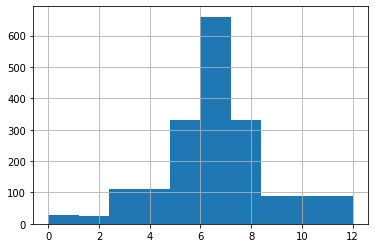

In [8]:
dataset['v_type_code'].hist()

In [9]:
# Delete the following states
# 0: ixnetwork-traffic-start
# 2: node-up
# 4: interface-up
# 6: tap-loss-stop
# 8: tap-delay-stop
# 10: ixnetwork-bgp-injection-stop
# 12: ixnetwork-bgp-hijacking-stop
data_drop_index = dataset[dataset['v_type_code'] % 2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] % 2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)


# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)


print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

dataset:
(930, 659)
testset:
(840, 659)


In [10]:
# train test split
column = dataset.columns
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 658) (1770,)
(930, 658) (930,)
(840, 658) (840,)


In [11]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

# Define models

In [16]:
# Decision tree

def decision_tree(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

    dt.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = dt.predict(X_test)

    current_time = time.time()

    print("DT Accuracy: %.2f" % accuracy_score(y_test, y_pred))

    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix dt:')
        print(cm)
        print('classification report dt:')
        print(classification_report(y_test, y_pred))


# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=estimators, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    print("n_estimators: %d" % estimators)
    print("RF Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))


# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=estimators, n_jobs=-1, objective='multi:softmax', num_class=5, random_state=0)

    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("n_estimators: %d" % estimators)
    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix xgb:')
        print(cm)
        print('classification report xgb:')
        print(classification_report(y_test, y_pred))


# MLP
def mlp(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    mlp = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(200, 200, 200, 200),
                        random_state=1, max_iter=10000, verbose=0, learning_rate_init=.1)
    mlp.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = mlp.predict(std_X_test)
    current_time = time.time()
    print("MLP Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix MLP:')
        print(cm)
        print('classification report MLP:')
        print(classification_report(y_test, y_pred))


# SVM
def svm_cross_validation(X, y):
    model = svm.SVC(kernel='rbf', probability=True)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in list(best_parameters.items()):
        print(para, val)
    model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(X, y)
    return model


def train_svm(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    # model = svm_cross_validation(std_X_train, y_train.ravel())
    model = svm.SVC(kernel='rbf', C=10, gamma=0.001, probability=True)
    model.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = model.predict(std_X_test)
    print("SVM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    current_time = time.time()
    print("train time： {}".format(middle_time - last_time))
    if show:
        print("test time： {}".format(current_time - middle_time))
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix svm:')
        print(cm)
        print('classification report svm:')
        print(classification_report(y_test, y_pred))

# Load generated dataset

In [85]:
type3_ganset = pd.read_csv('./csv/all/diff_dataset_type57.csv', index_col=None, header=0)

In [86]:
type3_ganset.astype({'v_type_code': 'int32'}).dtypes

try:
    type3_ganset.drop(columns=['Unnamed: 0'], inplace=True)
    type3_ganset.drop(columns=['Unnamed: 0.1'], inplace=True)
except Exception:
    print('aleardy deleted')

print(type3_ganset.shape)

aleardy deleted
(426, 658)


In [87]:
type3_ganset.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,p_/computes0/running_vms,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_type_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.012199,-431640.558681,-4.580351,-263.742580,-0.015027,-46803.637331,-1.678918,23.183673,-0.010764,57
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.013093,744.269809,-10.599317,261.526807,-0.038776,7072.453948,-1.584535,539.582744,-0.006059,57
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000955,-124547.136339,2.777748,-697.525439,0.004489,2334.705512,-0.841148,-293.169975,0.000731,57
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000015,-386930.474770,-1.021902,-487.892306,0.003923,-107470.407755,-0.810597,-249.158328,0.004131,57
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004952,119991.691821,0.105043,504.585339,0.006859,24437.645309,-0.195301,355.597190,0.009510,57


In [88]:
# if error
# type3_ganset['n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/control-processes/control-process/per-core-stats/per-core-stat/sirq'] = 0

# type3_ganset['v_/devices#IntGW-02/metrics/disk-device-write-requests-rate'] = 0

if 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue' not in type3_ganset.columns:
    type3_ganset['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue'] = 0
if 'n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/system-usages/system-usage/process-system-usages/process-system-usage/five-seconds' not in type3_ganset.columns:
    type3_ganset['n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/system-usages/system-usage/process-system-usages/process-system-usage/five-seconds'] = 0
             

In [89]:
X_gan_type3 = type3_ganset[column[:-1]]
y_gan_type3 = type3_ganset[column[-1]]
print(X_gan_type3.shape, y_gan_type3.shape)

(426, 658) (426,)


In [90]:
rf = random_forest(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
RF Accuracy: 0.89
train time： 0.9529259204864502
test time： 0.03391599655151367
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 134  46]
 [  0   2   0  47 319]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.97      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.74      0.74      0.74       180
          57       0.87      0.87      0.87       368

    accuracy                           0.89       840
   macro avg       0.92      0.92      0.92       840
weighted avg       0.89      0.89      0.89       840



In [91]:
rf_gan_type3 = random_forest(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

n_estimators: 100
RF Accuracy: 0.03
train time： 0.9013371467590332
test time： 0.017956972122192383
confusion matrix rf:
[[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [333  64  18  11]]
classification report rf:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          57       1.00      0.03      0.05       426

    accuracy                           0.03       426
   macro avg       0.25      0.01      0.01       426
weighted avg       1.00      0.03      0.05       426



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
xgb_gan_type3 = xgboost(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

n_estimators: 100
XGBOOST Accuracy: 0.51
train time： 11.925112009048462
test time： 0.02823472023010254
confusion matrix xgb:
[[  0   0   0]
 [  0   0   0]
 [128  81 217]]
classification report xgb:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          57       1.00      0.51      0.67       426

    accuracy                           0.51       426
   macro avg       0.33      0.17      0.22       426
weighted avg       1.00      0.51      0.67       426



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
decision_tree(X_train, y_train, X_gan_type3, y_gan_type3, show=True)

DT Accuracy: 0.37
train time： 0.35640811920166016
test time： 0.005478858947753906
confusion matrix dt:
[[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 31 199  40 156]]
classification report dt:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          57       1.00      0.37      0.54       426

    accuracy                           0.37       426
   macro avg       0.25      0.09      0.13       426
weighted avg       1.00      0.37      0.54       426



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# combine with original training dataset

In [26]:
dataset_new = pd.concat([dataset, type3_ganset], ignore_index=True, sort=False)
dataset_new = dataset_new.reset_index(drop=True)

In [27]:
dataset_new.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,p_/computes0/running_vms,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_type_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000010,4332.0,0.880124,36.0,0.000333,4332.0,2.713499,36.0,-0.000637,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016052,3986.0,0.933730,35.0,0.016481,3986.0,2.805528,35.0,-0.016620,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001333,4714.0,-0.046393,41.0,0.000471,4714.0,1.920622,41.0,-0.000124,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.099923,342.0,-12.543411,3.0,-0.116318,3568.0,-2.326906,32.0,-0.016621,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000207,854.0,-11.301755,7.0,-0.116844,740.0,-11.397061,6.0,-0.117156,1


<AxesSubplot:>

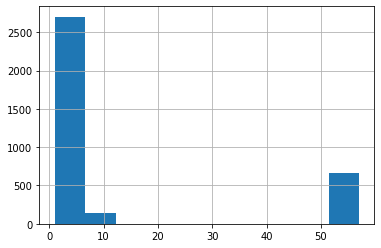

In [29]:
dataset_new['v_type_code'].hist()

In [30]:
X_train_new = dataset_new[column[:-1]]
X_test = testset[column[:-1]]
y_train_new = dataset_new[column[-1]]
y_test = testset[column[-1]]

In [33]:
decision_tree(X_train, y_train, X_test, y_test, show=True)

random_forest(X_train, y_train, X_test, y_test, show=True)

xgboost(X_train, y_train, X_test, y_test, show=True)

DT Accuracy: 0.82
train time： 0.3868710994720459
test time： 0.0051326751708984375
confusion matrix dt:
[[ 58   2   0   2   2]
 [  0  68   0   1   3]
 [  0   0 156   0   0]
 [  0   3   0 137  40]
 [  0   1   0  96 271]]
classification report dt:
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        64
           3       0.92      0.94      0.93        72
           9       1.00      1.00      1.00       156
          11       0.58      0.76      0.66       180
          57       0.86      0.74      0.79       368

    accuracy                           0.82       840
   macro avg       0.87      0.87      0.87       840
weighted avg       0.84      0.82      0.83       840

n_estimators: 100
RF Accuracy: 0.89
train time： 0.9117257595062256
test time： 0.021978139877319336
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 134  46]
 [  0   2   0  47 319]]
classification report rf:
    

In [32]:
decision_tree(X_train_new, y_train_new, X_test, y_test, show=True)

random_forest(X_train_new, y_train_new, X_test, y_test, show=True)

xgboost(X_train_new, y_train_new, X_test, y_test, show=True)

DT Accuracy: 0.83
train time： 1.1529390811920166
test time： 0.00518488883972168
confusion matrix dt:
[[ 52   5   0   1   6]
 [  2  59   1   3   7]
 [  0   0 156   0   0]
 [  1   1   0 130  48]
 [  0   9   0  55 304]]
classification report dt:
              precision    recall  f1-score   support

           1       0.95      0.81      0.87        64
           3       0.80      0.82      0.81        72
           9       0.99      1.00      1.00       156
          11       0.69      0.72      0.70       180
          57       0.83      0.83      0.83       368

    accuracy                           0.83       840
   macro avg       0.85      0.84      0.84       840
weighted avg       0.84      0.83      0.84       840

n_estimators: 100
RF Accuracy: 0.89
train time： 2.4824607372283936
test time： 0.022416353225708008
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   1 155   0   0]
 [  0   0   0 132  48]
 [  0   2   0  43 323]]
classification report rf:
      

In [ ]:
# test

In [7]:
# itu dataset path
dataset_path = '~/code/itu-ml-challenge/csv/dataset.csv'
testset_path = '~/code/itu-ml-challenge/csv/testset.csv'

# read dataset
dataset = pd.read_csv(dataset_path, index_col=None, header=0)
testset = pd.read_csv(testset_path, index_col=None, header=0)
print(dataset.shape, testset.shape)

(9670, 1000) (8683, 1000)


In [8]:
dataset.head()

,Unnamed: 0,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/local_gb_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/current_workload,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_/time,v_type,v_type_code
0,0,16,20,0,48,41472,257790,0,12,2,...,0.100425,174853276.0,11.431817,1263588.0,0.0,0.0,0.099783,1593395580,ixnetwork-traffic-start,0
1,1,16,20,0,48,41472,257790,0,12,2,...,0.099506,174854074.0,13.313681,1263595.0,0.0,0.0,0.116705,1593395640,ixnetwork-traffic-start,0
2,2,16,20,0,48,41472,257790,0,12,2,...,0.099506,174854758.0,13.313681,1263601.0,0.0,0.0,0.100463,1593395700,ixnetwork-traffic-start,0
3,3,16,20,0,48,41472,257790,0,12,2,...,0.099826,174855556.0,13.277844,1263608.0,0.0,0.0,0.116223,1593395760,ixnetwork-traffic-start,0
4,4,16,20,0,48,41472,257790,0,12,2,...,0.116494,174856338.0,13.277844,1263615.0,0.0,0.0,0.116614,1593395820,ixnetwork-traffic-start,0


In [9]:
# drop unnamed column

try:
    dataset = dataset.loc[:,(dataset !=0).any(axis=0)]
    testset = testset.loc[:,(testset !=0).any(axis=0)]
except:
    print('drop error')

try:
    dataset.drop(columns=['Unnamed: 0', 'v_/time', 'v_type'], inplace=True)
    testset.drop(columns=['Unnamed: 0', 'v_/time', 'v_type'], inplace=True)
except Exception:
    print('aleardy deleted')

In [10]:
print(dataset.shape, testset.shape)

(9670, 660) (8683, 660)


In [11]:
# Delete the following states
# 0: ixnetwork-traffic-start
# 2: node-up
# 4: interface-up
# 6: tap-loss-stop
# 8: tap-delay-stop
# 10: ixnetwork-bgp-injection-stop
# 12: ixnetwork-bgp-hijacking-stop
data_drop_index = dataset[dataset['v_type_code'] % 2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] % 2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)


# Try to combine 5 and 7 into one type.
# dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
# testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)


print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

dataset:
(4790, 660)
testset:
(4349, 660)


In [12]:
# train test split
column = dataset.columns
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9139, 659) (9139,)
(4790, 659) (4790,)
(4349, 659) (4349,)


In [13]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

In [14]:
X_train.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,p_/computes0/running_vms,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate
6,16,20,48,41472,257790,12,2,2,1,5,...,1398146.0,0.117346,184778378.0,13.372487,1401573.0,0.116937,174858104.0,11.376162,1263630.0,0.100582
7,16,20,48,41472,257790,12,2,2,1,5,...,1398152.0,0.132344,184779062.0,16.074580,1401579.0,0.133494,174858788.0,18.022304,1263636.0,0.148887
8,16,20,48,41472,257790,12,2,2,1,5,...,1398160.0,0.100077,184780114.0,11.441393,1401587.0,0.099904,174859726.0,11.385854,1263643.0,0.116852
9,16,20,48,41472,257790,12,2,2,1,5,...,1398167.0,0.133545,184780944.0,17.426420,1401594.0,0.133406,174860670.0,15.640423,1263651.0,0.133262
10,16,20,48,41472,257790,12,2,2,1,5,...,1398174.0,0.116604,184781742.0,13.861278,1401601.0,0.116827,174861354.0,15.790395,1263657.0,0.099945


In [18]:
decision_tree(X_train, y_train, X_test, y_test, show=True)

DT Accuracy: 0.25
train time： 0.773629903793335
test time： 0.013891220092773438
confusion matrix dt:
[[ 90 109  14  21   6  94]
 [ 14 117  16   0  20 205]
 [ 95 369 121   5  25 375]
 [ 60 392  73   1  30 389]
 [ 44 273  97   5 334  39]
 [ 81 352  43   6  24 410]]
classification report dt:
              precision    recall  f1-score   support

           1       0.23      0.27      0.25       334
           3       0.07      0.31      0.12       372
           5       0.33      0.12      0.18       990
           7       0.03      0.00      0.00       945
           9       0.76      0.42      0.54       792
          11       0.27      0.45      0.34       916

    accuracy                           0.25      4349
   macro avg       0.28      0.26      0.24      4349
weighted avg       0.30      0.25      0.24      4349



In [19]:
random_forest(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
RF Accuracy: 0.37
train time： 2.9657371044158936
test time： 0.04188990592956543
confusion matrix rf:
[[  0   0   0   0   0 334]
 [  0   0   0   0   0 372]
 [  0   0   0   0   0 990]
 [  0   0   0   0   0 945]
 [  0   0   0   0 703  89]
 [  0   0   0   0   0 916]]
classification report rf:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       334
           3       0.00      0.00      0.00       372
           5       0.00      0.00      0.00       990
           7       0.00      0.00      0.00       945
           9       1.00      0.89      0.94       792
          11       0.25      1.00      0.40       916

    accuracy                           0.37      4349
   macro avg       0.21      0.31      0.22      4349
weighted avg       0.24      0.37      0.26      4349



/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
xgboost(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
XGBOOST Accuracy: 0.34
train time： 43.12276029586792
test time： 0.13023066520690918
confusion matrix xgb:
[[172  67  52  16   1  26]
 [ 42 127 126   5  15  57]
 [ 65 405 353  50  32  85]
 [ 39 417 367  33  20  69]
 [  1  56   1   0 694  40]
 [ 44 388 309  21  47 107]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.47      0.51      0.49       334
           3       0.09      0.34      0.14       372
           5       0.29      0.36      0.32       990
           7       0.26      0.03      0.06       945
           9       0.86      0.88      0.87       792
          11       0.28      0.12      0.16       916

    accuracy                           0.34      4349
   macro avg       0.38      0.37      0.34      4349
weighted avg       0.38      0.34      0.33      4349

